We'll be using BraTS 2019 dataset for this.

link : (https://www.kaggle.com/datasets/aryashah2k/brain-tumor-segmentation-brats-2019)

Library Imports

In [1]:
import os
import sys
from torch import nn as nn
import numpy as np
from matplotlib import pyplot as plt
from typing import List, Dict, Union, Sequence, Callable
from monai.data import CacheDataset
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    Randomizable,
    Resized,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ToTensord,
)


In [2]:
root_dir = "/home/user/Desktop/Abul Hasan/Dataset/MICCAI_BraTS_2019_Data_Training/HGG"

In [3]:
def plot_data_distribution(num_train: int, num_val: int, num_test: int):
    """Plot number of data for train-set, val-set, and test-set after splitted"""

    # Create the bar chart
    bars = plt.bar(["Train", "Val", "Test"],
            [num_train, num_val, num_test], align='center', color=['green', 'red', 'blue'])

    # Add the data value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()


def load_datalist(
    root_dir: str
) -> List[Dict]:
    """
    Load image/label paths of dataset
    """
    
    datalist = []
    for data in os.listdir(root_dir):
        data_dir_path = os.path.join(root_dir, data)
        if os.path.isdir(data_dir_path):
            model_scans = ["flair", "t1", "t1ce", "t2"]
            image_paths = [os.path.join(data_dir_path, f"{data}_{model}.nii") for model in model_scans]
            label_path = os.path.join(data_dir_path, f"{data}_seg.nii")

            if (all(os.path.exists(path) for path in [*image_paths, label_path])):
                datalist.append({
                    "image": image_paths,
                    "label": label_path
                })

    return datalist


class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 4 to construct TC
            result.append(np.logical_or(d[key] == 1, d[key] == 4))
            # merge labels 1, 2 and 4 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 1, d[key] == 4), d[key] == 2
                )
            )
            # label 4 is ET
            result.append(d[key] == 4)
            d[key] = np.stack(result, axis=0).astype("float32")
        return d
    
    
class BratsDataset(Randomizable, CacheDataset):
    """
    Generate items for training, validation or test.
    """

    def __init__(
        self,
        root_dir: str,
        section: str,
        transform: Union[Sequence[Callable], Callable] = (),
        val_frac: float = 0.15,
        test_frac: float = 0.05,
        seed: int = 0,
        cache_num: int = sys.maxsize,
        cache_rate: float = 1.0,
        num_workers: int = 0,
    ) -> None:
        if not os.path.isdir(root_dir) or not os.path.exists(root_dir):
            raise RuntimeError(
                f"Cannot find dataset directory: {root_dir}."
            )

        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.set_random_state(seed=seed)
        self.indices: np.ndarray = np.array([])
        
        data = self._generate_data_list(root_dir)
        CacheDataset.__init__(
            self, data, transform, cache_num=cache_num, cache_rate=cache_rate, num_workers=num_workers
        )

    def get_indices(self) -> np.ndarray:
        """
        Get the indices of datalist used in this dataset.
        """
        return self.indices

    def randomize(self, data: List[int]) -> None:
        self.R.shuffle(data)

    def _generate_data_list(self, root_dir: str) -> List[Dict]:
        datalist = load_datalist(root_dir)
        return self._split_datalist(datalist)

    def _split_datalist(self, datalist: List[Dict]) -> List[Dict]:
        length = len(datalist)
        indices = np.arange(length)
        self.randomize(indices)

        val_length = int(length * self.val_frac)
        test_length = int(length * self.test_frac)
        if self.section == "training":
            self.indices = indices[val_length+test_length:]
        elif self.section == "validation":
            self.indices = indices[test_length:val_length+test_length]
        else:
            self.indices = indices[:test_length]

        return [datalist[i] for i in self.indices]

Original Data Preprocessing

In [4]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"], spatial_size=(96, 96, 96), mode="nearest"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

Augmented Data Preprocessing

Spacingd: Resamples the image and label data to the specified voxel spacing (1.0, 1.0, 1.0) using bilinear interpolation for the image and nearest-neighbor interpolation for the label.

Resized: Resizes the image and label data to a spatial size of (96, 96, 96) using nearest-neighbor interpolation.

RandFlipd: Randomly flips the image and label data along the specified axes (0, 1, and 2) with a probability of 0.5 for each axis.

RandRotate90d: Randomly rotates the image and label data by 90 degrees with a probability of 0.5.

RandScaleIntensityd: Randomly scales the intensity of the image by a factor of ±0.1 with a probability of 1.0.

RandShiftIntensityd: Randomly shifts the intensity of the image by an offset of ±0.1 with a probability of 1.0.

RandGaussianNoised: Adds Gaussian noise to the image with a mean of 0.0 and a standard deviation of 0.01, with a probability of 0.5.

NormalizeIntensityd: Normalizes the intensity of the image on a per-channel basis, considering only nonzero values.

ToTensord: Converts the image and label data into PyTorch tensors.

In [5]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, 
    ConvertToMultiChannelBasedOnBratsClassesd, Orientationd, Spacingd, 
    Resized, RandFlipd, RandScaleIntensityd, RandShiftIntensityd, 
    NormalizeIntensityd, RandGaussianNoised, RandAdjustContrastd, RandRotate90d
)
from monai.data import ImageDataset
from torch.utils.data import DataLoader, ConcatDataset
# augmentation for the data
transform_2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"], spatial_size=(96,96,96), mode="nearest"),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        RandRotate90d(keys=["image", "label"], prob=0.5 ),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        RandGaussianNoised(keys="image", mean=0.0, std=0.01, prob=0.5),  # Low noise
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

DataLoader

In [6]:
# original data 
train_ds = BratsDataset(
    root_dir=root_dir,
    section="training",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
# augmented data
train_2_ds = BratsDataset(
    root_dir=root_dir,
    section="training",
    transform=transform_2,
    cache_rate=0.0,
    num_workers=4
)

#combining multiple datasets
# different years can be combined using concat dataset function (monai lib)
combined_train_ds = ConcatDataset([train_ds, train_2_ds])

# Final train variable
train_loader = DataLoader(
    combined_train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=4
)

#original data
val_ds = BratsDataset(
    root_dir=root_dir,
    section="validation",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
# augmented data
val_2_ds = BratsDataset(
    root_dir=root_dir,
    section="validation",
    transform=transform_2,
    cache_rate=0.0,
    num_workers=4
)
#combining multiple datasets
combined_val_ds = ConcatDataset([val_ds, val_2_ds])

# Final validation variable
val_loader = DataLoader(
    combined_val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4
)

Visualization

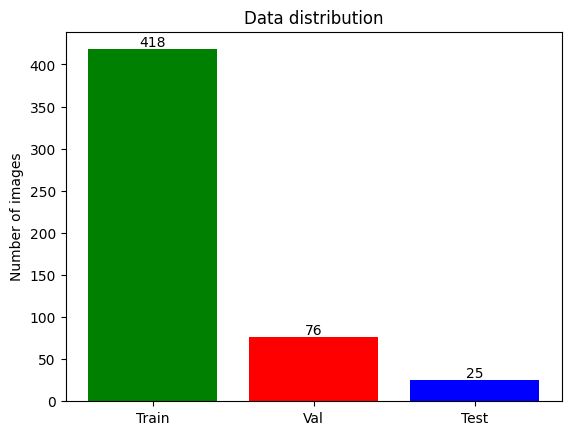

In [7]:
# visualizing data distribution 
val_frac = val_ds.val_frac
test_frac = val_ds.test_frac

num_train = len(combined_train_ds)
num_val = len(combined_val_ds)
num_test = int(test_frac * num_val / val_frac)

plot_data_distribution(num_train, num_val, num_test)

image shape: torch.Size([4, 96, 96, 96])


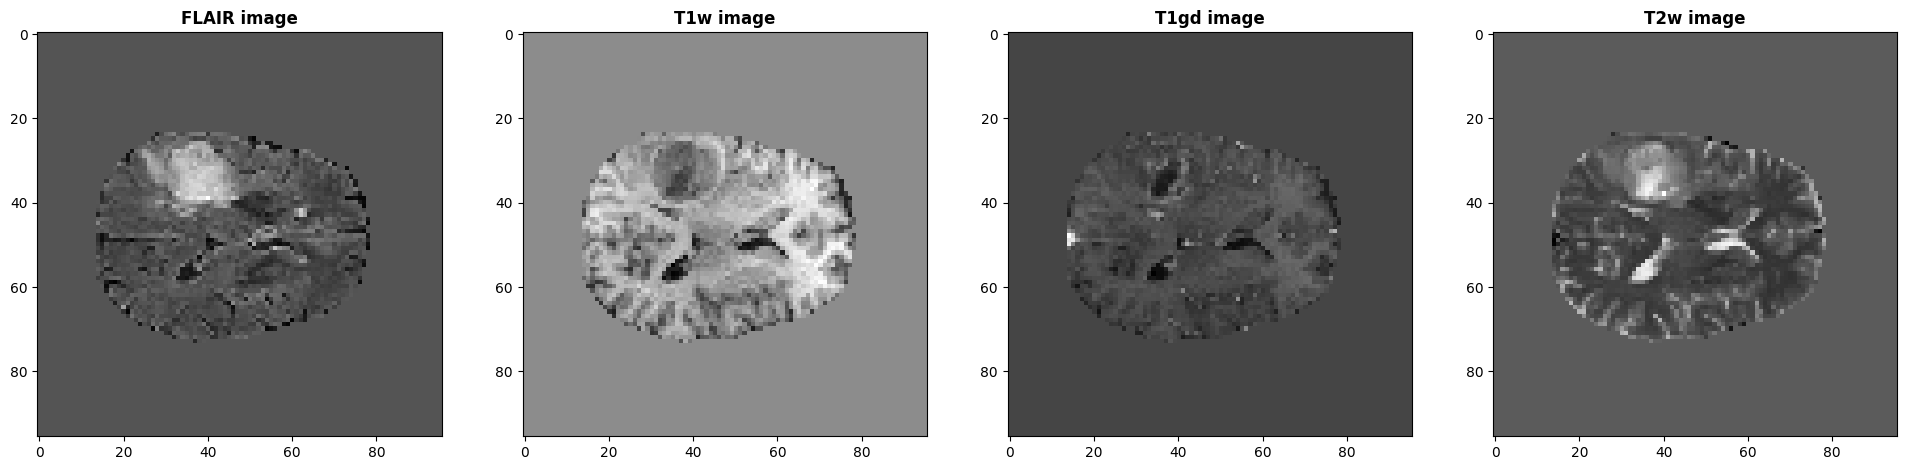

label shape: torch.Size([3, 96, 96, 96])


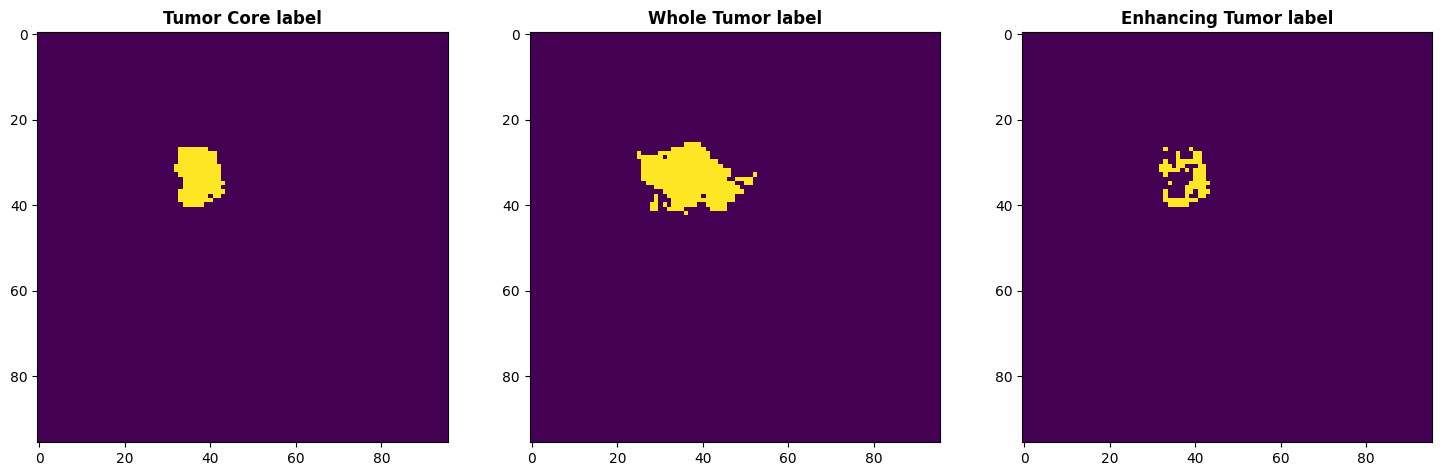

In [8]:
# Non-Augmented
image_channels = ['FLAIR', 'T1w', 'T1gd', 'T2w']
label_channels = ['Tumor Core', 'Whole Tumor', 'Enhancing Tumor']

# pick one image from BratsDataset to visualize and check the 4 channels
val_data_example = val_ds[23]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(len(image_channels)):
    plt.subplot(1, 4, i + 1)
    plt.title(f"{image_channels[i]} image", weight='bold')
    plt.imshow(val_data_example["image"][i, :, :, val_data_example['image'].shape[-1] // 2], cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(len(label_channels)):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{label_channels[i]} label", weight='bold')
    plt.imshow(val_data_example["label"][i, :, :, val_data_example['image'].shape[-1] // 2])
plt.show()

image shape: torch.Size([4, 96, 96, 96])


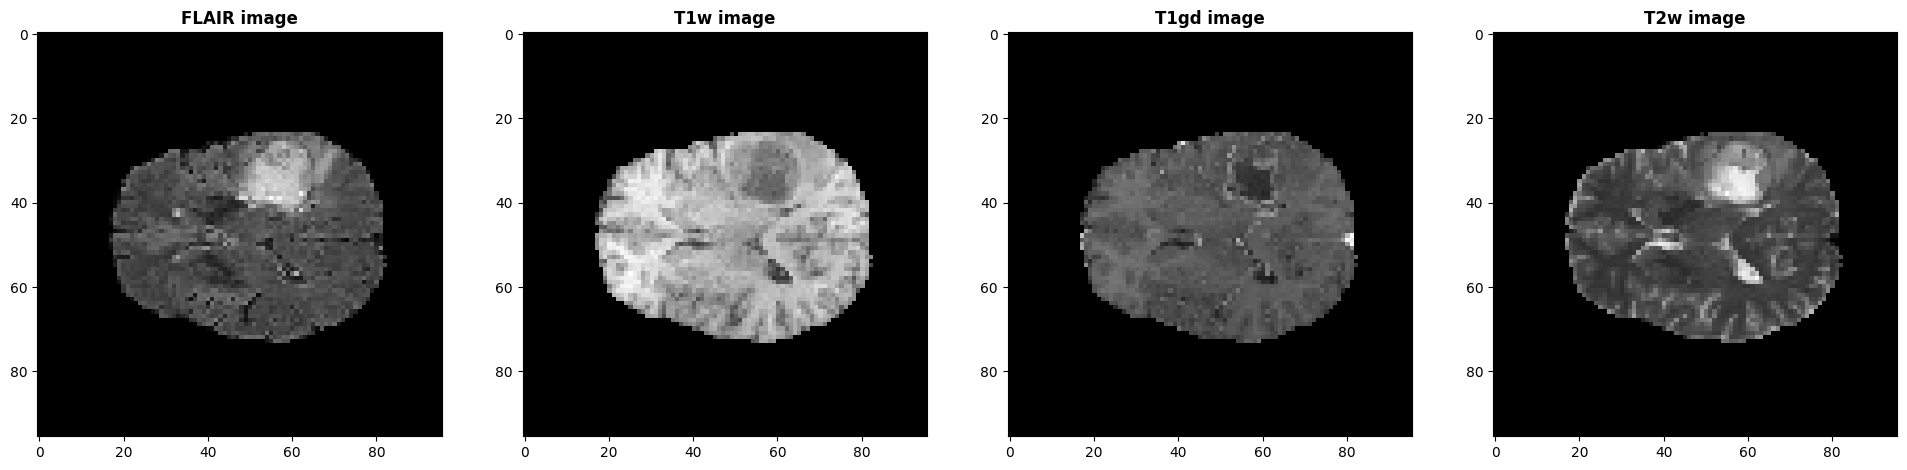

label shape: torch.Size([3, 96, 96, 96])


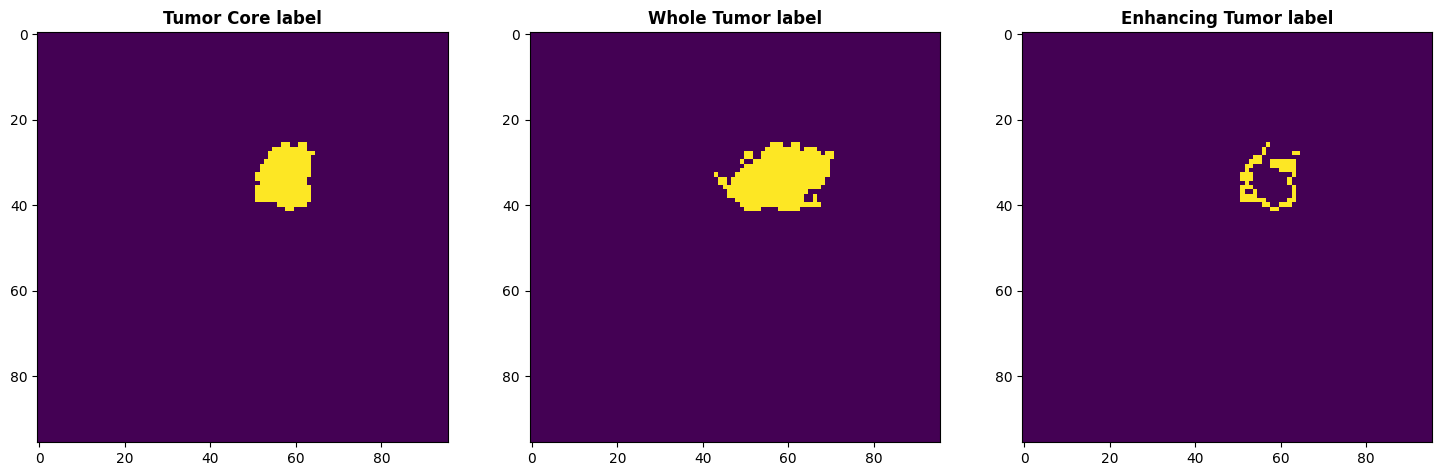

In [9]:
# Augmented Image
image_channels = ['FLAIR', 'T1w', 'T1gd', 'T2w']
label_channels = ['Tumor Core', 'Whole Tumor', 'Enhancing Tumor']

# pick one image from BratsDataset to visualize and check the 4 channels
val_data_example = val_2_ds[23]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(len(image_channels)):
    plt.subplot(1, 4, i + 1)
    plt.title(f"{image_channels[i]} image", weight='bold')
    plt.imshow(val_data_example["image"][i, :, :, val_data_example['image'].shape[-1] // 2], cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(len(label_channels)):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{label_channels[i]} label", weight='bold')
    plt.imshow(val_data_example["label"][i, :, :, val_data_example['image'].shape[-1] // 2])
plt.show()

 Now we can use val_loader and train_loader for our training purposes as they contain concatenated data.
 
 trying to save them back in .nii file format lead to corrupt data so don't do that